# 0. PRELIMINARIES

In [1]:
!pip install -q torchsummary torchgeometry segmentation-models-pytorch

In [2]:
import os
import gc
import random
import time
from math import ceil, floor
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn import init
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

import torchvision.transforms.functional as TF
from torchvision import transforms

from torchsummary import summary
from torchgeometry.losses import one_hot

import segmentation_models_pytorch as smp

import wandb

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
!nvidia-smi

Thu Nov 16 23:42:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. DATASET

## 1.1. DATA LOADING

In [5]:
class NeopolypDataset(Dataset):
    def __init__(self, images_path, masks_path):
        super(NeopolypDataset, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [images_path + image_name for image_name in images_list]
        masks_list = [masks_path + mask_name for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
    
    def __getitem__(self, idx):
        img_path = self.images_list[idx]
        mask_path = self.masks_list[idx]
        
        # Open image
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        # Resize
        resize = transforms.Resize(size=(768, 1024), interpolation=transforms.InterpolationMode.BILINEAR)
        image = resize(image)
        mask = resize(mask)
        
        return image, mask
    
    def __len__(self):
        return len(self.images_list)

In [6]:
class SplitNeopolypDataset(NeopolypDataset):
    def __init__(self, dataset, augment=False):
        self.dataset = dataset
        self.augment = augment
    
    def train_transform(self, image, mask):        
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(576, 640))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        # Random rotation
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        
        # Random adjustments for brightness, contrast, and saturation
        image = TF.adjust_brightness(image, random.uniform(0.8, 1.2))
        image = TF.adjust_contrast(image, random.uniform(0.8, 1.2))
        image = TF.adjust_saturation(image, random.uniform(0.8, 1.2))
        
        # Random gaussian blur
        image = TF.gaussian_blur(image, random.choice([3, 5, 7]))
        
        # Random perspective transformation
        if random.random() > 0.5:
            perspective_params = transforms.RandomPerspective.get_params(
               width=image.width, height=image.height, distortion_scale=0.5
            )
            image = TF.perspective(image, *perspective_params)
            mask = TF.perspective(mask, *perspective_params)
        
        # Transform to tensor
        to_tensor = transforms.ToTensor()
        image = to_tensor(image)
        to_tensor = transforms.PILToTensor()
        mask = to_tensor(mask)
        
        # Normalize
        normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        image = normalize(image)
        
        # Turn pixel values to class masks (red: neopolyp - 0, green: non-neopolyp - 1, background - 2)
        mask = mask / 255
        mask = torch.where(mask>0.65, 1.0, 0.0)
        mask[2, :, :] = 0.0001
        mask = torch.argmax(mask, 0).type(torch.int64)
        
        return image, mask
    
    def valid_transform(self, image, mask):        
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(576, 640))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        # Transform to tensor
        to_tensor = transforms.ToTensor()
        image = to_tensor(image)
        to_tensor = transforms.PILToTensor()
        mask = to_tensor(mask)
        
        # Normalize
        normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        image = normalize(image)
        
        # Turn pixel values to class masks (red: neopolyp - 0, green: non-neopolyp - 1, background - 2)
        mask = mask / 255
        mask = torch.where(mask>0.65, 1.0, 0.0)
        mask[2, :, :] = 0.0001
        mask = torch.argmax(mask, 0).type(torch.int64)
        
        return image, mask
    
    def __getitem__(self, idx):
        image, mask = self.dataset[idx] 
        if self.augment:
            image, mask = self.train_transform(image, mask)
        else:
            image, mask = self.valid_transform(image, mask)
        return image, mask

    def __len__(self):
        return len(self.dataset)        

In [7]:
IMAGES_PATH = "/kaggle/input/bkai-igh-neopolyp/train/train/"
MASKS_PATH =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"

neopolyp_dataset = NeopolypDataset(images_path=IMAGES_PATH, masks_path=MASKS_PATH)

In [8]:
TOTAL_SIZE = len(neopolyp_dataset)
TRAIN_SIZE = int(TOTAL_SIZE * 0.8)
VALID_SIZE = TOTAL_SIZE - TRAIN_SIZE
BATCH_SIZE = 6

train_dataset, valid_dataset = random_split(neopolyp_dataset, [TRAIN_SIZE, VALID_SIZE])

train_dataset_no_aug = SplitNeopolypDataset(train_dataset, augment=False)
train_dataset_aug = SplitNeopolypDataset(train_dataset, augment=True)

valid_dataset = SplitNeopolypDataset(valid_dataset)
train_dataset = ConcatDataset([train_dataset_no_aug, train_dataset_aug])

print("Length of train dataset:", len(train_dataset))
print("Length of valid dataset:", len(valid_dataset))

Length of train dataset: 1600
Length of valid dataset: 200


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 1.2. DATA VISUALIZATION

### 1.2.1. Training set

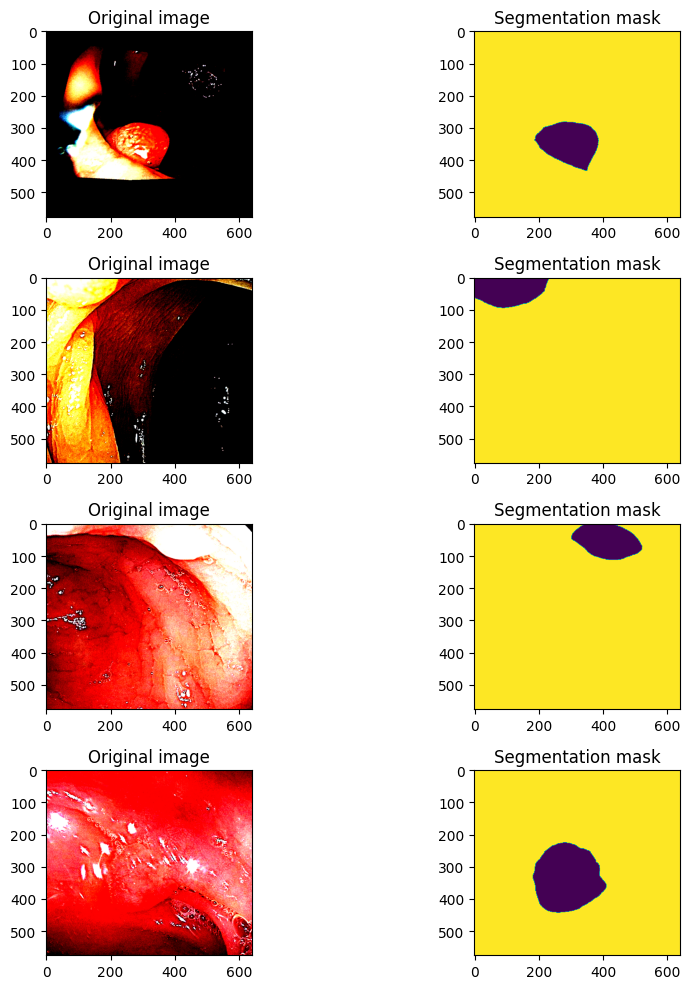

In [10]:
images, masks = next(iter(train_dataloader))

fig, axes = plt.subplots(4, 2, figsize=(10, 10))

for i in range(4):
    # Image
    axes[i, 0].imshow(images[i].permute(1, 2, 0))
    axes[i, 0].set_title("Original image")

    # Mask
    axes[i, 1].imshow(masks[i])
    axes[i, 1].set_title("Segmentation mask")

plt.tight_layout()
plt.show()

### 1.2.2. Validation set

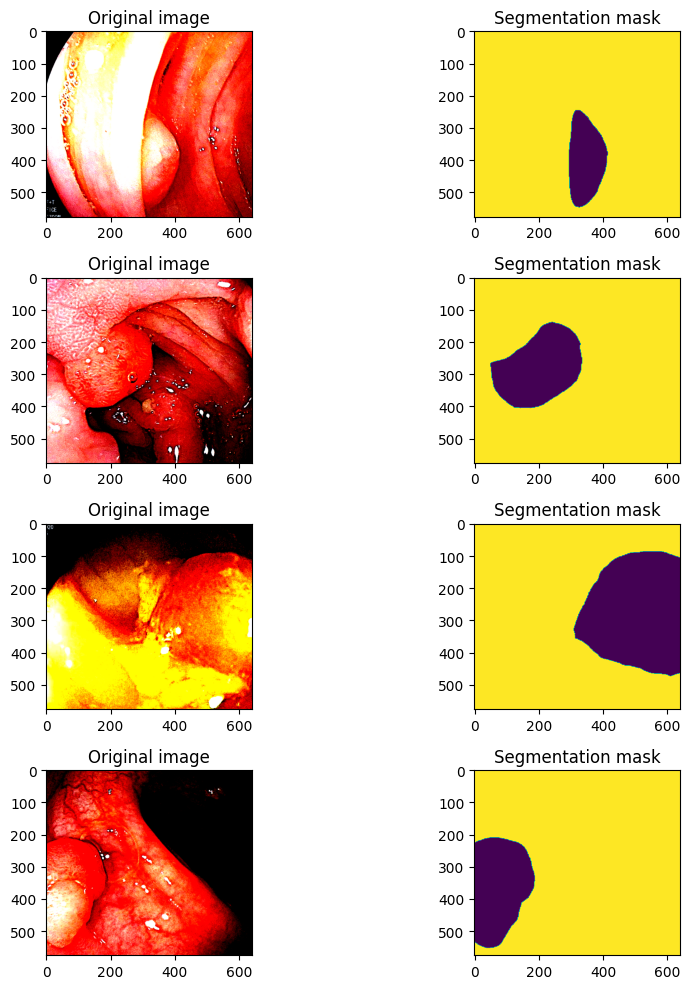

In [11]:
images, masks = next(iter(valid_dataloader))

fig, axes = plt.subplots(4, 2, figsize=(10, 10))

for i in range(4):
    # Image
    axes[i, 0].imshow(images[i].permute(1, 2, 0))
    axes[i, 0].set_title("Original image")

    # Mask
    axes[i, 1].imshow(masks[i])
    axes[i, 1].set_title("Segmentation mask")

plt.tight_layout()
plt.show()

# 2. MODEL

## 2.1. ARCHITECTURE COMPONENTS

### 2.1.1. Encoder block

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        
        mid_channels = int(out_channels/2)
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(p=0.6)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu(x)
        
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.elu(x)
        
        next_layer = self.max_pool(x)
        skip_layer = x
        
        return next_layer, skip_layer

### 2.1.2. Decoder block

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        
        mid_channels = int(3 * out_channels/2)
        
        self.transposed_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(2 * out_channels, mid_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.elu = nn.ELU() 
        self.dropout = nn.Dropout(p=0.6)
    
    def forward(self, x, skip_layer):
        x = self.transposed_conv(x)
        
        # Concatenate channel-wise (1st dim: batch size, 2nd dim: channel,...)
        x = torch.cat([x, skip_layer], axis=1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu(x)
        
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.elu(x)
        
        return x

### 2.1.3. Bottleneck

In [ ]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BottleneckBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.6)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

### 2.1.4. Attention block

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, gate_channels, feature_channels, intermediate_channels):
        super(AttentionBlock, self).__init__()
        
        self.gate_transform = nn.Sequential(
            nn.Conv2d(gate_channels, intermediate_channels, kernel_size=1,stride=2,padding=0,bias=True),
            nn.BatchNorm2d(intermediate_channels)
            )
        
        self.feature_transform = nn.Sequential(
            nn.Conv2d(feature_channels, intermediate_channels, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(intermediate_channels)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(intermediate_channels, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU()
        
    def forward(self, g, x):
        g_out = self.gate_transform(g)
        x_out = self.feature_transform(x)
        psi = self.relu(g_out + x_out)
        psi = self.psi(psi)
        
        psi = F.interpolate(psi, scale_factor=2.0, mode='bilinear')
        return g*psi

## 2.2 LOSS FUNCTION

In [12]:
class CEDiceLoss(nn.Module):
    def __init__(self, weights):
        super(CEDiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        # ---INPUT NOT TENSOR---
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}".format(type(input)))
        # ---WRONG INPUT SHAPE---
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}".format(input.shape))
        # ---MISMATCHED-SHAPE INPUT & TARGET---
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("Input and target shapes must be the same. Got: {}".format(input.shape, input.shape))
        # ---MISMATCHED-DEVICE INPUT & TARGET---
        if not input.device == target.device:
            raise ValueError("Input and target must be in the same device. Got: {}" .format(input.device, target.device))
        # ---UNEQUAL WEIGHTING VS. CLASSES---
        if not self.weights.shape[1] == input.shape[1]:
            raise ValueError("The number of weights must equal the number of classes")
        # ---WEIGHTS NOT SUMMING TO 1---
        if not torch.sum(self.weights).item() == 1:
            raise ValueError("The sum of all weights must equal 1")
            
        # Cross Entropy Loss, weighted 
        ce_loss = nn.CrossEntropyLoss(self.weights)(input, target)
        
        # Compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # Create the one-hot label tensor
        target_one_hot = one_hot(target, num_classes=input.shape[1], device=input.device, dtype=input.dtype)

        # Dice Score, weighted
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        dice_score = torch.sum(dice_score * self.weights, dim=1)
        
        # Average over all training examples and all classes
        return torch.mean(1. - dice_score) + ce_loss

## 2.3. TRAINING

### 2.3.1. Parameters

In [ ]:
NUM_CLASSES = 3
NUM_EPOCHS = 200

# Hyperparameter for training
LEARNING_RATE = 6e-04
WEIGHTS = torch.Tensor([[0.5, 0.45, 0.05]]).cuda()

### 2.3.2. Full architecture

In [ ]:
class UNet(nn.Module):
    
    def __init__(self, for_inference=False,
                 train_dataloader=None, valid_dataloader=None,
                 loss_function=None, optimizer=None,
                 learning_rate_scheduler=None, learning_rate=None,
                 num_epochs=None, num_classes=3):
        
        super(UNet, self).__init__()
        
        if not for_inference:
            self.train_dataloader = train_dataloader
            self.valid_dataloader = valid_dataloader
            self.loss_function = loss_function
            self.num_epochs = num_epochs

        # Encoder blocks
        self.enc1 = EncoderBlock(3, 32)
        self.enc2 = EncoderBlock(32, 64)
        self.enc3 = EncoderBlock(64, 128)
        self.enc4 = EncoderBlock(128, 256)
        self.enc5 = EncoderBlock(256, 512)

        # Bottleneck block
        self.bottleneck = BottleneckBlock(512, 1024)

        # Decoder blocks
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)
        self.dec5 = DecoderBlock(64, 32)
        
        # Attention blocks
        self.att1 = AttentionBlock(512, 1024, 768)
        self.att2 = AttentionBlock(256, 512, 384)
        self.att3 = AttentionBlock(128, 256, 192)
        self.att4 = AttentionBlock(64, 128, 96)
        self.att5 = AttentionBlock(32, 64, 48)

        # 1x1 convolution
        self.out = nn.Conv2d(32, num_classes, kernel_size=1, padding='same')
        
        if not for_inference:
            self.optimizer = optimizer(self.parameters(), lr=learning_rate, weight_decay=1e-05)
            self.learning_rate_scheduler = learning_rate_scheduler(self.optimizer, step_size=12, gamma=0.6)
            self.initialize_weights()
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal_(m.weight, 1.0, 0.02)
                init.constant_(m.bias, 0)
    
    def forward(self, image):
        n1, s1 = self.enc1(image)
        n2, s2 = self.enc2(n1)
        n3, s3 = self.enc3(n2)
        n4, s4 = self.enc4(n3)
        n5, s5 = self.enc5(n4)
        
        btn = self.bottleneck(n5)
        
        """
        a_btn = self.att1(s5, btn)
        n6 = self.dec1(a_btn, s5)
        
        a_n6 = self.att2(s4, n6)
        n7 = self.dec2(a_n6, s4)
        
        a_n7 = self.att3(s3, n7)
        n8 = self.dec3(a_n7, s3)
        
        a_n8 = self.att4(s2, n8)
        n9 = self.dec4(a_n8, s2)
        
        a_n9 = self.att5(s1, n9)
        n10 = self.dec5(a_n9, s1)
        
        output = self.out(n10)
        """
        
        a_s5 = self.att1(s5, btn)
        n6 = self.dec1(btn, a_s5)
        
        a_s4 = self.att2(s4, n6)
        n7 = self.dec2(n6, a_s4)
        
        a_s3 = self.att3(s3, n7)
        n8 = self.dec3(n7, a_s3)
        
        a_s2 = self.att4(s2, n8)
        n9 = self.dec4(n8, a_s2)
        
        a_s1 = self.att5(s1, n9)
        n10 = self.dec5(n9, a_s1)
        
        output = self.out(n10)
        
        return output
    
    def save_checkpoint(self, epoch, train_loss_epoch, valid_loss_epoch, checkpoint_path):
        if isinstance(self, nn.DataParallel):
            model_state_dict = self.module.state_dict()
        else:
            model_state_dict = self.state_dict()
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'learning_rate_scheduler_state_dict': self.learning_rate_scheduler.state_dict(),
            'train_loss_epoch': train_loss_epoch,
            'valid_loss_epoch': valid_loss_epoch
        }
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        torch.save(checkpoint, checkpoint_path)

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        if isinstance(self, nn.DataParallel):
            self.module.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.learning_rate_scheduler.load_state_dict(checkpoint['learning_rate_scheduler_state_dict'])
        return checkpoint['epoch'], checkpoint['train_loss_epoch'], checkpoint['valid_loss_epoch']
    
    def train_step(self, images, targets):
        images, targets = images.to(device), targets.to(device)
        self.optimizer.zero_grad()
        outputs = self.forward(images)
        loss = self.loss_function(outputs, targets.long())
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def valid_step(self, images, targets):
        images, targets = images.to(device), targets.to(device)
        outputs = self.forward(images)
        loss = self.loss_function(outputs, targets.long())
        return loss.item()
    
    def train_model(self):
        
        last_valid_loss = 999999
        wandb.watch(self)
        
        for epoch in range(self.num_epochs):
            
            start = time.time()
            
            # --------------------TRAINING--------------------
            self.train()
            train_loss_epoch = 0
            
            for images, targets in tqdm(train_dataloader, desc='Epoch {}/{}'.format(epoch + 1, self.num_epochs)):
                train_loss_epoch += self.train_step(images, targets)
            
            del images
            del targets
            gc.collect()
            torch.cuda.empty_cache()
            
            end = time.time()
            
            train_loss_epoch /= len(train_dataloader)
            
            # --------------------TESTING--------------------
            self.eval()
            with torch.no_grad():
                valid_loss_epoch = 0

                for images, targets in tqdm(valid_dataloader, desc='Epoch {}/{}'.format(epoch + 1, self.num_epochs)):
                    valid_loss_epoch += self.valid_step(images, targets)

                valid_loss_epoch /= len(valid_dataloader)
            
            # --------------------LOG RESULT--------------------
            wandb.log({"learning_rate": self.optimizer.param_groups[0]['lr'],
                       "train_loss": train_loss_epoch,
                       "valid_loss": valid_loss_epoch,
                      })
            self.learning_rate_scheduler.step()
            
            # --------------------VERBOSE---------------------
            print("Epoch {0:<5}: Training loss = {1:^8.4f} - Validation loss = {2:^8.4f} - Time taken = {3:^8.4f}s.\n".format(epoch+1, train_loss_epoch, valid_loss_epoch, end-start))
            
            # --------------------CHECKPOINT--------------------
            if valid_loss_epoch < last_valid_loss:
                checkpoint_path = "/kaggle/working/checkpoint/" + "model_checkpoint.pth"
                self.save_checkpoint(epoch+1, train_loss_epoch, valid_loss_epoch, checkpoint_path)
                last_valid_loss = valid_loss_epoch
            
        wandb.finish()
        
    def train_model_continue(self, checkpoint_path):
        start_epoch, train_loss, valid_loss = self.load_checkpoint(checkpoint_path)
        self.num_epochs -= start_epoch
        self.train_model()

In [13]:
class PretrainedUNet(smp.Unet):
    
    def __init__(self, for_inference=False,
                 train_dataloader=None, valid_dataloader=None,
                 loss_function=None, optimizer=None,
                 learning_rate_scheduler=None, learning_rate=None,
                 num_epochs=None, num_classes=3,
                 # For pre-trained model
                 encoder_name="resnet34", encoder_depth=5, encoder_weights="imagenet",
                 decoder_channels=[512, 256, 128, 64, 32], decoder_attention_type='scse'):
        
        # Using the pretrained model
        super(PretrainedUNet, self).__init__(
            encoder_name=encoder_name,
            encoder_depth=encoder_depth,
            encoder_weights=encoder_weights,
            decoder_channels=decoder_channels,
            decoder_attention_type=decoder_attention_type,
            classes=num_classes
        )
        
        if not for_inference:
            self.train_dataloader = train_dataloader
            self.valid_dataloader = valid_dataloader
            self.loss_function = loss_function
            self.num_epochs = num_epochs
            self.optimizer = optimizer(self.parameters(), lr=learning_rate, weight_decay=1e-05)
            self.learning_rate_scheduler = learning_rate_scheduler(self.optimizer, step_size=12, gamma=0.6)
    
    def save_checkpoint(self, epoch, train_loss_epoch, valid_loss_epoch, checkpoint_path):
        if isinstance(self, nn.DataParallel):
            model_state_dict = self.module.state_dict()
        else:
            model_state_dict = self.state_dict()
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'learning_rate_scheduler_state_dict': self.learning_rate_scheduler.state_dict(),
            'train_loss_epoch': train_loss_epoch,
            'valid_loss_epoch': valid_loss_epoch
        }
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        torch.save(checkpoint, checkpoint_path)

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        if isinstance(self, nn.DataParallel):
            self.module.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.learning_rate_scheduler.load_state_dict(checkpoint['learning_rate_scheduler_state_dict'])
        return checkpoint['epoch'], checkpoint['train_loss_epoch'], checkpoint['valid_loss_epoch']
    
    def train_step(self, images, targets):
        images, targets = images.to(device), targets.to(device)
        self.optimizer.zero_grad()
        outputs = self.forward(images)
        loss = self.loss_function(outputs, targets.long())
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def valid_step(self, images, targets):
        images, targets = images.to(device), targets.to(device)
        outputs = self.forward(images)
        loss = self.loss_function(outputs, targets.long())
        return loss.item()
    
    def train_model(self):
        
        last_valid_loss = 999999
        wandb.watch(self)
        
        for epoch in range(self.num_epochs):
            
            start = time.time()
            
            # --------------------TRAINING--------------------
            self.train()
            train_loss_epoch = 0
            
            for images, targets in tqdm(train_dataloader, desc='Epoch {}/{}'.format(epoch + 1, self.num_epochs)):
                train_loss_epoch += self.train_step(images, targets)
            
            del images
            del targets
            gc.collect()
            torch.cuda.empty_cache()
            
            end = time.time()
            
            train_loss_epoch /= len(train_dataloader)
            
            # --------------------TESTING--------------------
            self.eval()
            with torch.no_grad():
                valid_loss_epoch = 0

                for images, targets in tqdm(valid_dataloader, desc='Epoch {}/{}'.format(epoch + 1, self.num_epochs)):
                    valid_loss_epoch += self.valid_step(images, targets)

                valid_loss_epoch /= len(valid_dataloader)
            
            # --------------------LOG RESULT--------------------
            wandb.log({"learning_rate": self.optimizer.param_groups[0]['lr'],
                       "train_loss": train_loss_epoch,
                       "valid_loss": valid_loss_epoch,
                      })
            self.learning_rate_scheduler.step()
            
            # --------------------VERBOSE---------------------
            print("Epoch {0:<5}: Training loss = {1:^8.4f} - Validation loss = {2:^8.4f} - Time taken = {3:^8.4f}s.\n".format(epoch+1, train_loss_epoch, valid_loss_epoch, end-start))
            
            # --------------------CHECKPOINT--------------------
            if valid_loss_epoch < last_valid_loss:
                checkpoint_path = "/kaggle/working/checkpoint/" + "model_checkpoint.pth"
                self.save_checkpoint(epoch+1, train_loss_epoch, valid_loss_epoch, checkpoint_path)
                last_valid_loss = valid_loss_epoch
            
        wandb.finish()
        
    def train_model_continue(self, checkpoint_path):
        start_epoch, train_loss, valid_loss = self.load_checkpoint(checkpoint_path)
        self.num_epochs -= start_epoch
        self.train_model()

### 2.3.3. Begin training

In [ ]:
# --------------------Either self-trained model--------------------
unet = UNet(train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           loss_function=CEDiceLoss(weights=WEIGHTS),
           optimizer=optim.Adam,
           learning_rate_scheduler=lr_scheduler.StepLR,
           learning_rate=LEARNING_RATE,
           num_epochs=NUM_EPOCHS,
           num_classes=NUM_CLASSES,)
unet = nn.DataParallel(unet)
unet.to(device)

In [ ]:
# --------------------Or pre-trained model--------------------
unet = PretrainedUNet(train_dataloader=train_dataloader,
                      valid_dataloader=valid_dataloader,
                      loss_function=CEDiceLoss(weights=WEIGHTS),
                      optimizer=optim.Adam,
                      learning_rate_scheduler=lr_scheduler.StepLR,
                      learning_rate=LEARNING_RATE,
                      num_epochs=NUM_EPOCHS,
                      num_classes=NUM_CLASSES,) # The pre-trained params are used as default
unet = nn.DataParallel(unet)
unet.to(device)

In [ ]:
wandb.init(project="unet-for-neopolyp-segmentation")
unet.module.train_model()

In [ ]:
wandb.finish()

### 2.3.4. Continue training

In [14]:
NUM_CLASSES = 3
NUM_EPOCHS = 200

# Hyperparameter for training
LEARNING_RATE = 2e-04
WEIGHTS = torch.Tensor([[0.525, 0.425, 0.05]]).cuda()

In [ ]:
CHECKPOINT_PATH = '/kaggle/input/checkpoint/model_checkpoint.pth'

unet = PretrainedUNet(train_dataloader=train_dataloader,
                      valid_dataloader=valid_dataloader,
                      loss_function=CEDiceLoss(weights=WEIGHTS),
                      optimizer=optim.Adam,
                      learning_rate_scheduler=lr_scheduler.StepLR,
                      learning_rate=LEARNING_RATE,
                      num_epochs=NUM_EPOCHS,
                      num_classes=NUM_CLASSES,)
unet = nn.DataParallel(unet)
unet.to(device)

wandb.init(project="unet-for-neopolyp-segmentation")
unet.module.train_model_continue(CHECKPOINT_PATH)

In [17]:
wandb.finish()

learning_rate,█████▄▄▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▄▅▃▃▃▃▃▃▂▃▂▂▃▂▁▂▂▂▁▁▃▃▁▂▁▁
valid_loss,▂▁▆▃▇▆▇▄▁▅▅▃▆█▂▄▄▅▃▆▅▁█▄▅▄▆▄▆
learning_rate,0.0
train_loss,0.53212
valid_loss,0.59221


### 2.3.5. Save latest model

In [16]:
checkpoint_path = "/kaggle/working/checkpoint/" + "model_checkpoint_latest.pth"
unet.module.save_checkpoint(0, 0, 0, checkpoint_path)

# 3. SUBMISSION

## 3.1. TEST DATASET

In [18]:
class NeopolypTestDataset(Dataset):
    def __init__(self, images_path):
        super(NeopolypTestDataset, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path + image_name for image_name in images_list]
        
        self.images_list = images_list
    
    def transform(self, image):
        # Resize
        # resize = transforms.Resize(size=(640, 896), interpolation=transforms.InterpolationMode.BILINEAR)
        resize = transforms.Resize(size=(768, 1024), interpolation=transforms.InterpolationMode.BILINEAR)
        image = resize(image)      
        
        # Transform to tensor
        to_tensor = transforms.ToTensor()
        image = to_tensor(image)
        
        # Normalize
        normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        image = normalize(image)
        
        return image
    
    def __getitem__(self, idx):
        img_path = self.images_list[idx]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data)
        
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)

In [19]:
TEST_PATH = '/kaggle/input/bkai-igh-neopolyp/test/test/'
TEST_BATCH_SIZE = 8

neopolyp_test_dataset = NeopolypTestDataset(images_path=TEST_PATH)
test_dataloader = DataLoader(neopolyp_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

## 3.2. PREDICTION

In [27]:
checkpoint = torch.load("/kaggle/working/checkpoint/model_checkpoint_latest.pth")
model_state_dict = checkpoint['model_state_dict']
model = PretrainedUNet(for_inference=True)
model.load_state_dict(model_state_dict)
model = nn.DataParallel(model)

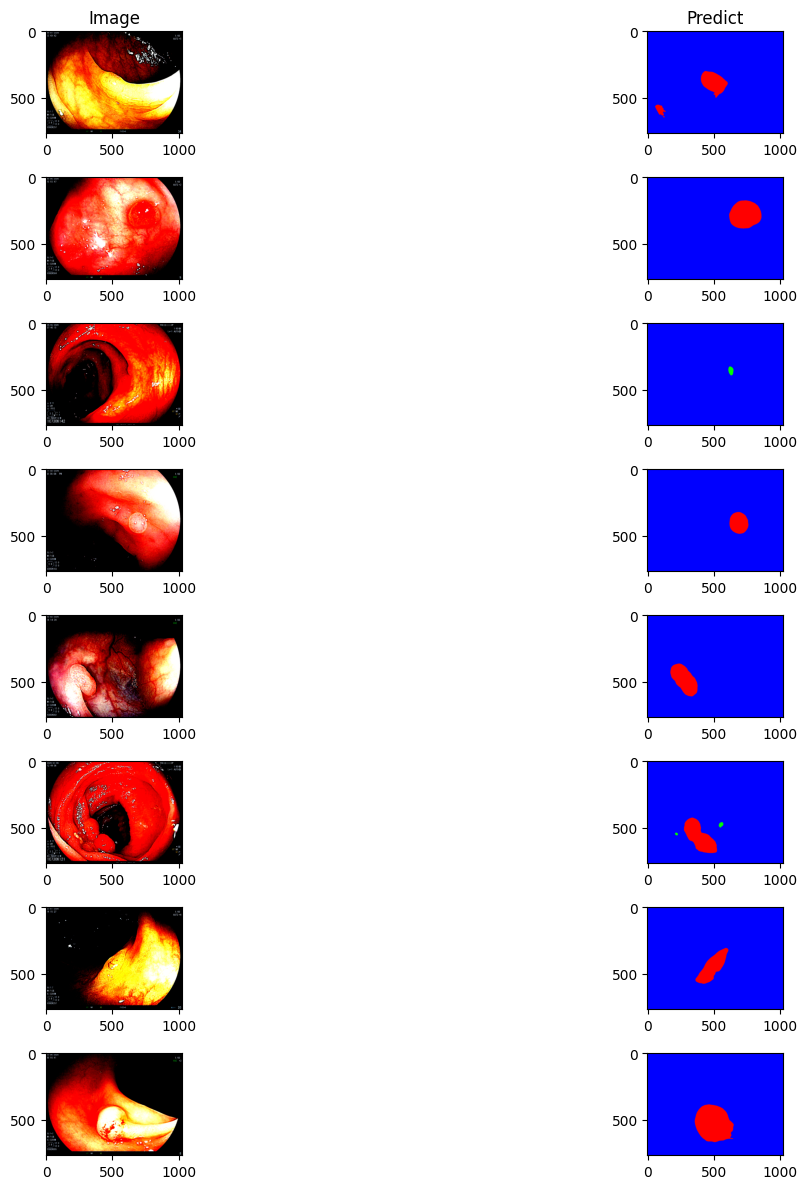

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

images, _, _, _ = next(iter(test_dataloader))
images = images.to(device)

fig, axes = plt.subplots(TEST_BATCH_SIZE, 2, figsize=(16, 12))
axes[0][0].set_title('Image');
axes[0][1].set_title('Predict');

model.eval()
with torch.no_grad():
    for i in range(TEST_BATCH_SIZE):
        axes[i][0].imshow(images[i].permute(1, 2, 0).cpu());
        image = images[i].unsqueeze(0).to(device)
        predict = model(image)
        axes[i][1].imshow(F.one_hot(torch.argmax(predict.squeeze(), 0).cpu()).float())
    
        del predict
        torch.cuda.empty_cache()

plt.tight_layout()
plt.show()

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# model.to("cpu")

if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")

model.eval()
with torch.no_grad():
    for images, paths, heights, weights in test_dataloader:

        for i in range(TEST_BATCH_SIZE):
            image = images[i].unsqueeze(0).to(device)
            # image = images[i].unsqueeze(0)
            predict = model(image)

            image_id = paths[i].split('/')[-1].split('.')[0]
            filename = image_id + ".png"
            mask2img = transforms.Resize((heights[i].item(), weights[i].item()), interpolation=transforms.InterpolationMode.NEAREST)(transforms.ToPILImage()(F.one_hot(torch.argmax(predict.squeeze(), 0)).permute(2, 0, 1).float()))
            mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))
            
            del image
            del predict
            gc.collect()
            torch.cuda.empty_cache()

## 3.3. CONVERT MASK TO CSV

In [30]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r

In [31]:
MASK_DIR_PATH = '/kaggle/working/predicted_masks'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'submission.csv', index=False)

/kaggle/working/predicted_masks/e4a17af18f72c8e6166a915669c99390.png
/kaggle/working/predicted_masks/50534bca540e24f489284b8e6953ad88.png
/kaggle/working/predicted_masks/f8e26031fbb5e52c41545ba55aadaa77.png
/kaggle/working/predicted_masks/6f67b5df7cdf3f33c3ca4d5060a633a8.png
/kaggle/working/predicted_masks/268d4b4ef4d95ceea11957998906d369.png
/kaggle/working/predicted_masks/e19769fa2d37d32780fd497e1c0e9082.png
/kaggle/working/predicted_masks/3425b976973f13dd311a65d2b46d0a60.png
/kaggle/working/predicted_masks/b21960c94b0aab4c024a573c692195f8.png
/kaggle/working/predicted_masks/cb2eb1ef57af2ed9fbb63b28163a7459.png
/kaggle/working/predicted_masks/02fa602bb3c7abacdbd7e6afd56ea7bc.png
/kaggle/working/predicted_masks/0af3feff05dec1eb3a70b145a7d8d3b6.png
/kaggle/working/predicted_masks/e73749a0d21db70dd094a7f32574d6c7.png
/kaggle/working/predicted_masks/2a365b5574868eb60861ee1ff0b8a4f6.png
/kaggle/working/predicted_masks/faef7fdb2d45b21960c94b0aab4c024a.png
/kaggle/working/predicted_masks/f6

In [32]:
print(os.listdir('/kaggle/working/'))

['wandb', 'predicted_masks', '.virtual_documents', 'checkpoint', 'submission.csv']


In [33]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working


/kaggle/working/submission.csv

In [34]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'/kaggle/working/checkpoint/model_checkpoint.pth')

/kaggle/working


/kaggle/working/checkpoint/model_checkpoint.pth